### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.vision.interpret import *
import fastai; fastai.__version__

'1.0.55.dev0'

In [3]:
data_path = Path("../../data/siim_acr_pneu/"); data_path.ls()

[PosixPath('../../data/siim_acr_pneu/train'),
 PosixPath('../../data/siim_acr_pneu/clas_df.csv'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-test'),
 PosixPath('../../data/siim_acr_pneu/models'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-train'),
 PosixPath('../../data/siim_acr_pneu/train-rle.csv'),
 PosixPath('../../data/siim_acr_pneu/seg_df.csv'),
 PosixPath('../../data/siim_acr_pneu/learn'),
 PosixPath('../../data/siim_acr_pneu/test')]

In [4]:
torch.cuda.set_device(7)

In [5]:
from mask_functions import *
from skimage.measure import label

### Workflow

- 1) Run segmentation on all valid and test images
- 2) Run classification on all test valid and images
- 3) Find optimal thresh
- 4) Submit

In [6]:
# this is needed or div=False
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

In [7]:
sz = 224

In [9]:
torch.nn.Module.dump_patches = True

In [476]:
clas_learn = Learner(**torch.load(data_path/f'learn/clas-chexpert-ft-resnet34-{sz}'))
seg_learn = Learner(**torch.load(data_path/f'learn/seg-chexpert-ft-resnext34-{sz}'))

### 1) Run seg on valid/test

In [429]:
# Normal Preds
seg_valid_probs, seg_valid_targs = seg_learn.get_preds(DatasetType.Valid)
seg_test_probs, seg_test_targs = seg_learn.get_preds(DatasetType.Test)

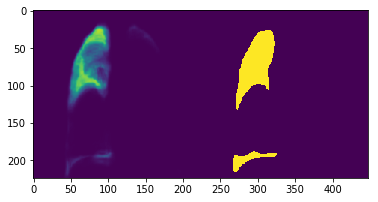

In [430]:
plt.imshow(np.concatenate((seg_valid_probs[0][1], seg_valid_targs[0][0]), axis=1))

In [431]:
from fastai.basic_train import _loss_func2activ
def _seg_tta_only(learn:Learner, ds_type:DatasetType=DatasetType.Valid, scale:float=1.35) -> Iterator[List[Tensor]]:
    "Computes the outputs for non-flip and flip_lr augmented inputs"
    dl = learn.dl(ds_type)
    ds = dl.dataset
    old = ds.tfms
    augm_tfm = [o for o in learn.data.train_ds.tfms if o.tfm not in
               (crop_pad, flip_lr, dihedral, zoom)]
    try:
        pbar = master_bar(range(2))
        for i in pbar:
#             row = 1 if i&1 else 0
#             col = 1 if i&2 else 0
#             flip = i&4
#             d = {'row_pct':row, 'col_pct':col, 'is_random':False}
#             tfm = [*augm_tfm, zoom(scale=scale, **d), crop_pad(**d)]
#             if flip: tfm.append(flip_lr(p=1.))
            tfm = [] # to remove random crop resize aug
            if i: tfm.append(flip_lr(p=1.))
            ds.tfms = tfm
            yield get_preds(learn.model, dl, pbar=pbar, activ=_loss_func2activ(learn.loss_func))[0]
    finally: ds.tfms = old

In [434]:
# flip_lr TTA preds
non_flip_preds, flip_preds = list(_seg_tta_only(seg_learn, ds_type=DatasetType.Valid, scale=1))
preds1, preds2 = non_flip_preds, torch.stack([torch.flip(o, dims=[-1]) for o in flip_preds], dim=0)
seg_valid_probs = (preds1 + preds2)/2

non_flip_preds, flip_preds = list(_seg_tta_only(seg_learn, ds_type=DatasetType.Test, scale=1))
preds1, preds2 = non_flip_preds, torch.stack([torch.flip(o, dims=[-1]) for o in flip_preds], dim=0)
seg_test_probs = (preds1 + preds2)/2

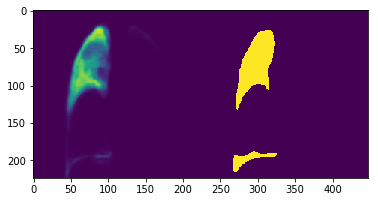

In [435]:
plt.imshow(np.concatenate((seg_valid_probs[0][1], seg_valid_targs[0][0]), axis=1))

### 1a) Semantic Dice (deprecated)

In [438]:
# def semantic_dice(input, target, t):
#     '''
#     semantic dice score with threshold 
#     input: 1 mask probability per image
#     target: 1 mask target per image
#     '''
#     input_hard = input[:,1,:,:] > t
#     n = input_hard.shape[0]
#     inputs = input_hard.float().view(n,-1)
#     targs = target.float().view(n,-1)
#     intersect = (inputs * targs).sum()
#     union = (inputs+targs).sum()
#     dice = ((2. * intersect) / union)
#     return dice

# # dice scores at different probability thresholds
# for t in np.linspace(0,1,21):
#     d = semantic_dice(seg_valid_probs, seg_valid_targs, t=t)
#     print(t, d)

### 1b) Instance Dice

In [439]:
# rles for each validation image
train_rle_df = pd.read_csv(data_path/'train-rle.csv')
valid_image_ids = [Path(o).stem for o in seg_learn.data.valid_ds.items]
valid_rle_dict = {o:train_rle_df[train_rle_df.ImageId == o][' EncodedPixels'].values for o in valid_image_ids}

In [440]:
def rles2masks(rles):
    'convert rles into list of (1024,1024) binary (0,1) masks'
    masks = []
    for rle in rles:
        maskimg = PIL.Image.fromarray(rle2mask(rle, 1024, 1024).T.astype(np.uint8))
        assert np.all(np.unique(np.asarray(maskimg)) == np.array([0,255]))
        masks.append((np.asarray(maskimg)/255).astype(np.uint8))
    return masks

In [441]:
# create masks for all validation images
valid_instance_targs = [np.array(rles2masks(valid_rle_dict[k])) for k in valid_image_ids]
len(valid_instance_targs)

237

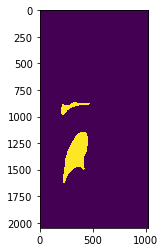

In [442]:
# test
masks = valid_instance_targs[0]
for m in masks: assert np.all(np.unique(m) == np.array([0,1]))
plt.imshow(np.concatenate(masks));

In [443]:
seg_test_probs.shape

torch.Size([1377, 2, 224, 224])

In [444]:
def prob2preds(prob, t, removal_thres=100):
    '''
    create instance preds from single mask probs 
    removal_thres: remove an instance pred if # of total pixels < removal_thres
    '''
    input_hard = prob[1,:,:] > t
    label_image = label(input_hard)
    unique_labels = np.unique(label_image)[1:]
    if len(unique_labels) > 0:
        instance_preds = [(label_image == l).astype(np.uint8) for l in unique_labels]
        instance_preds_resized = [np.asarray(PIL.Image.fromarray(arr).resize((1024,1024), 
                                    resample=PIL.Image.NEAREST)) for arr in instance_preds]
        # remove tiny instance preds
        if removal_thres is not None:
            instance_preds_resized = [arr for arr in instance_preds_resized if np.sum(arr) > removal_thres]
            if len(instance_preds_resized) == 0: instance_preds_resized = ['-1']
    else: instance_preds_resized = ['-1']

    return np.array(instance_preds_resized)

In [445]:
t = 0.3
valid_instance_preds = [prob2preds(prob, t, removal_thres=100) for prob in seg_valid_probs]

/home/turgutluk/.conda/envs/my_fastai/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


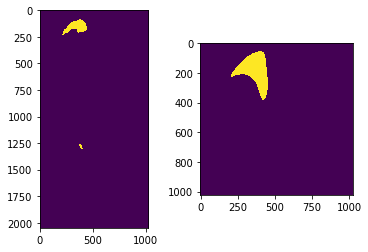

In [452]:
# test
i = np.random.choice(range(len(valid_instance_preds)))
masks = valid_instance_preds[i]
targ = valid_instance_targs[i]
if masks != '-1':
    for m in masks: assert np.all(np.unique(m) == np.array([0,1]))
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(np.concatenate(masks)); ax[1].imshow(targ[0]);

In [453]:
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm_notebook

def instance_dice(instance_preds, instance_targs):
    '''
    instance dice score with threshold 
    instance_preds: list of N_i mask (0,1) per image
    instance_targs: list of M_i mask (0,1) target per image
    '''
    
#     # for plotting
#     fig,axes=plt.subplots(1,2)
#     axes[0].imshow(np.concatenate(valid_instance_targs[i]))
#     axes[1].imshow(np.concatenate(valid_instance_preds[i]))
    
    scores = []
    for i in (range(len(instance_preds))):
        if np.all(valid_instance_preds[i] == np.array(['-1'])): scores.append(0)
        else:
            m,_,_ = valid_instance_targs[i].shape
            n,_,_ = valid_instance_preds[i].shape

            targs = valid_instance_targs[i].reshape(m,-1)
            preds = valid_instance_preds[i].reshape(n,-1)

            # intersect: matrix of targ x preds (M, N)
            intersect = ((targs[:,None,:]*preds[None,:,:]) > 0).sum(2)    
            targs_area, preds_area = targs.sum(1), preds.sum(1)
            union = targs_area[:, None] + preds_area[None,:]

            dice = (2*intersect / union); dice
            dice_scores = dice[linear_sum_assignment(1-dice)]
            mean_dice_score = sum(dice_scores) / max(n, m) # unmatched gt or preds are counted as 0
            scores.append(mean_dice_score)
    return scores

In [454]:
# at t = 0.5
best_dice, best_seg_thres, best_removal_thres = 0, None, None
dice_scores = {}
for removal_t in np.arange(0, 2000, 200):
    for t in tqdm_notebook(np.linspace(0,1,21)):
        valid_instance_preds = [prob2preds(prob, t, removal_thres=removal_t) for prob in seg_valid_probs]
        dice_score = np.mean(instance_dice(valid_instance_preds, valid_instance_targs))
        if dice_score > best_dice: best_dice, best_seg_thres, best_removal_thres= dice_score, t, removal_t
        dice_scores[t] = dice_score

/home/turgutluk/.conda/envs/my_fastai/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [455]:
print(best_dice, best_seg_thres, best_removal_thres)
dice_scores

0.3984740533624218 0.25 1000


{0.0: 0.0021079666069327846,
 0.05: 0.27308106378075425,
 0.1: 0.3542908769317951,
 0.15000000000000002: 0.3824053792434275,
 0.2: 0.39560692578509793,
 0.25: 0.3982179985123133,
 0.30000000000000004: 0.38689200872002905,
 0.35000000000000003: 0.369859235200378,
 0.4: 0.3485473020823702,
 0.45: 0.30518713408292936,
 0.5: 0.25765358827535756,
 0.55: 0.2182279533097275,
 0.6000000000000001: 0.18737996384005204,
 0.65: 0.15031058280850368,
 0.7000000000000001: 0.11739504481803656,
 0.75: 0.08981849828388944,
 0.8: 0.06573782333709348,
 0.8500000000000001: 0.048686309369109206,
 0.9: 0.034247545916423185,
 0.9500000000000001: 0.009894849957401149,
 1.0: 0.0}

### 2) Run clas on valid/test

In [193]:
from sklearn.metrics import confusion_matrix

In [26]:
# Normal Preds
clas_valid_probs, clas_valid_targs = clas_learn.get_preds(DatasetType.Valid)
clas_test_probs, clas_test_targs = clas_learn.get_preds(DatasetType.Test)

In [477]:
# TTA
clas_valid_probs, clas_valid_targs = clas_learn.TTA(beta=0.4, scale=1, ds_type=DatasetType.Valid)
clas_test_probs, clas_test_targs = clas_learn.TTA(beta=0.4, scale=1, ds_type=DatasetType.Test)

In [479]:
clas_valid_probs, clas_valid_targs

(tensor([[5.1396e-01, 4.8604e-01],
         [4.1681e-03, 9.9583e-01],
         [1.7890e-02, 9.8211e-01],
         ...,
         [4.4993e-01, 5.5007e-01],
         [1.0095e-02, 9.8991e-01],
         [1.9587e-04, 9.9980e-01]]), tensor([0, 1, 1,  ..., 1, 1, 1]))

### 3) Grid search for best thres -  Calculate approx LB score 

In [480]:
def find_best_thres(best_dice=best_dice, best_seg_thres=best_seg_thres, best_removal_thres=best_removal_thres):
    "grid search for only cls_thres"
    best_score, best_cls_thres = 0, None
    
    for cls_thres in np.linspace(0,1,21):
        clas_valid_hard = clas_valid_probs[:, 1] > cls_thres
        cm = confusion_matrix(clas_valid_targs, clas_valid_hard)

        P_0_0 = cm[0,0] / cm[0, :].sum()
        P_1_1 = cm[1,1] / cm[1, :].sum()

        # public LB ratios
        R_1, R_0 = 0.7886, 0.2114
        score_cls, score_seg = R_1*P_1_1, R_0*P_0_0*best_dice
        total = score_cls + score_seg

        # update
        if total > best_score:
            best_score, best_cls_thres  = total, cls_thres

    return best_score, best_cls_thres, best_seg_thres, best_removal_thres

In [481]:
best_score, best_cls_thres, best_seg_thres, best_removal_thres = find_best_thres()
print(best_score, best_cls_thres, best_seg_thres)

0.8208691300412049 0.2 0.25


### 4) Submit

- Convert segmentation probas to binary 
- Resize to 1024, 1024
- Separate instances
- Convert individual masks to rle

In [482]:
cls_thres, seg_thres, removal_thres = best_cls_thres, best_seg_thres, best_removal_thres
cls_thres, seg_thres, removal_thres

(0.2, 0.25, 1000)

In [483]:
# convert all soft mask predictions to hard predictions
seg_test_hard = (seg_test_probs[:,1,:,:] > seg_thres).squeeze(1); seg_test_hard.shape

torch.Size([1377, 224, 224])

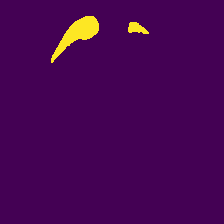

In [484]:
ImageSegment(seg_test_hard[4][None,:])

In [485]:
# extract test image ids
test_image_ids = np.array([o.stem for o in seg_learn.data.test_ds.items])

In [486]:
# find images to submit mask predictions for
has_pneumo = to_np((clas_test_probs[:, 1] < cls_thres)).astype(bool)

mask_test_image_ids = test_image_ids[has_pneumo]
mask_test_hard = seg_test_hard[tensor(has_pneumo)]

no_mask_test_image_ids = test_image_ids[~has_pneumo]

In [487]:
mask_test_image_ids.shape, no_mask_test_image_ids.shape, mask_test_hard.shape

((159,), (1218,), torch.Size([159, 224, 224]))

In [488]:
def tensor2pil(t):
    return (PIL.Image.fromarray((to_np(t)*255).astype(np.uint8), mode='L')
                .resize((1024,1024), PIL.Image.NEAREST))

In [489]:
def maskarray2rles(maskarray, removal_thres=None):
    rles = []
    labeled_maskarray = label(maskarray)
    unique_labels = list(np.unique(labeled_maskarray)[1:])
    for l in unique_labels:
        m = (labeled_maskarray == l).astype(np.uint8)
        if (removal_thres is not None) and (np.sum(m) <= removal_thres):
            continue
        else:
            rle = mask2rle(m*255, *(1024,1024))
            rles.append(rle)
    if len(rles) == 0: rles = ['-1']
    return rles

In [490]:
# create rle for all test predictions
all_image_ids = []
all_rles = []
for i in tqdm_notebook(range(len(mask_test_image_ids))):    
    image_id, t = mask_test_image_ids[i], mask_test_hard[i]
    maskimg = tensor2pil(t)
    maskarray = np.asarray(maskimg).T
    if len(np.unique(maskarray)) != 1: rles = maskarray2rles(maskarray, removal_thres=best_removal_thres)
    else: rles = ['-1']
    for rle in rles:
        all_image_ids.append(image_id)
        all_rles.append(rle)

In [491]:
len(all_image_ids), len(all_rles)

(234, 234)

In [492]:
sub1 = pd.DataFrame({"ImageId": all_image_ids, "EncodedPixels":all_rles})
sub2 = pd.DataFrame({"ImageId": no_mask_test_image_ids, "EncodedPixels":"-1"})

final_sub = pd.concat([sub1, sub2])
final_sub.to_csv("sub.csv", index=False)

In [493]:
sub2 = pd.DataFrame({"ImageId": no_mask_test_image_ids, "EncodedPixels":"-1"})

In [494]:
final_sub = pd.concat([sub1, sub2])

In [495]:
final_sub.to_csv("sub.csv", index=False)

In [496]:
from IPython.display import FileLink

In [497]:
FileLink("sub.csv")

/home/turgutluk/git/siim_acr_pneu/sub.csv